In [1]:
!nvidia-smi

Tue Nov  8 16:34:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8    15W /  N/A |    249MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale
import torchvision.transforms as T

from pathlib import Path

# data_dir = Path('/app/notebooks/image_stitching/sample_data/keyboard')
data_dir = Path('/app/notebooks/image_stitching/sample_data/keyboard_1-camera')
assert data_dir.exists()

In [3]:
device = torch.device('cpu')

In [4]:
available_exts = ['.jpg', '.png']

def load_dir(dir_path, size=(256, 256)):
    dir_path = Path(dir_path)
    
    resize_f = T.Resize(size)
    
    imgs = []
    for file_path in dir_path.iterdir():
        if file_path.suffix not in available_exts:
            continue
        
        i_img = Image.open(file_path)
        i_timg = kornia.utils.image_to_tensor(np.array(i_img), False).float() / 255.
        i_timg = i_timg.to(device)
        i_timg = resize_f(i_timg[:, :3, :, :])
        imgs.append(i_timg)
        
    timg = torch.cat(imgs, dim=0)
    timg_gray = kornia.color.rgb_to_grayscale(timg)
    return timg, timg_gray

def torch_resize(img, scale_factor):
    width = int(img.shape[3] * scale_factor)
    height = int(img.shape[2] * scale_factor)
    dim = (height, width)
    
    resize_f = T.Resize(dim)

    # resize image
    resized = resize_f(img)
    return resized

def drop_by_idx(t, idx):
    return torch.cat([t[0:idx], t[idx+1:]])

In [5]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

In [6]:
PS = 41

sift = kornia.feature.TFeat(True).to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)

descriptor = sift

resp = BlobDoG()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)

nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              scale_space_response=True,#We need that, because DoG operates on scale-space
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(32, 
                                                                    angle_detector=kornia.feature.OriNet(True)),
                              mr_size=6.0,
                              minima_are_also_good=True).to(device) #dark blobs are as good as bright.

# def get_features(src_img, target_img):
#     img_pair = torch.cat([src_img, target_img], dim=0)

#     with torch.no_grad():
#         lafs, resps = detector(img_pair)
#         patches =  kornia.feature.extract_patches_from_pyramid(img_pair, lafs, PS)
#         B, N, CH, H, W = patches.size()
#         # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
#         # So we need to reshape a bit :) 
#         descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
#         scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)
#         return lafs, descs, matches
    
def get_features(src_img, target_img):
    with torch.no_grad():
        src_lafs, src_resps = detector(src_img)
        target_lafs, target_resps = detector(target_img)
        src_patches =  kornia.feature.extract_patches_from_pyramid(src_img, src_lafs, PS)
        target_patches =  kornia.feature.extract_patches_from_pyramid(target_img, target_lafs, PS)
        src_B, src_N, src_CH, src_H, src_W = src_patches.size()
        target_B, target_N, target_CH, target_H, target_W = target_patches.size()
        # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
        # So we need to reshape a bit :) 
        src_descs = descriptor(src_patches.view(src_B * src_N, src_CH, src_H, src_W)).view(src_B, src_N, -1)
        target_descs = descriptor(target_patches.view(target_B * target_N, target_CH, target_H, target_W)).view(target_B, target_N, -1)
        scores, matches = kornia.feature.match_snn(src_descs[0], target_descs[0], 0.9)
        return src_lafs, target_lafs, src_descs, target_descs, matches
    
# Difference-of-Gaussians + OriNet + TFeat
# def get_keypoints(src_img, target_img):
#     lafs, descs, matches = get_features(src_img, target_img)

#     src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
#     dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()
#     return src_pts, dst_pts, matches

# Difference-of-Gaussians + OriNet + TFeat
def get_keypoints(src_img, target_img):
    src_lafs, target_lafs, src_descs, target_descs, matches = get_features(src_img, target_img)

    src_pts = src_lafs[0,matches[:,0], :, 2].data.cpu().numpy()
    dst_pts = target_lafs[0,matches[:,1], :, 2].data.cpu().numpy()
    return src_pts, dst_pts, matches

In [7]:
def find_root(timg):
    numOfFeats = []
    for i in range(len(timg_gray)):
        temp = 0
        for j in range(len(timg_gray)):
            if i != j:
                _, _, matches = get_keypoints(timg_gray[i:i+1], timg_gray[j:j+1])
                temp += len(matches)
        numOfFeats.append(temp)
    
    return np.argmax(np.array(numOfFeats))

def cleanse(im):
    for i in range(im.shape[1]-1, 0, -1):
        if (im[:, i] != 0).any():
            im = im[:, :i]
            break
            
    for i in range(0, im.shape[1]):
        if (im[:, i] != 0).any():
            im = im[:, i:]
            break
            
    for i in range(0, im.shape[0]):
        if (im[i] != 0).any():
            im = im[i:]
            break
            
    for i in range(im.shape[0]-1, 0, -1):
        if (im[i] != 0).any():
            im = im[:i]
            break
    
    return im

def stitch_images(gray_im1, gray_im2, im1, im2):
    pad_image = T.Pad((im1.shape[1], im1.shape[2]), fill=0, padding_mode='constant')
    
    gray_im1 = pad_image(gray_im1)

    dst_pts, src_pts, goodMatches = get_keypoints(gray_im1[None, ...], gray_im2[None, ...])

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)

    print(im1.shape)
    im1 = pad_image(im1)
    print(im1.shape)

    nimg1 = im1.cpu().permute(1,2,0).numpy()
    nimg2 = im2.cpu().permute(1,2,0).numpy()

    warped = cv2.warpPerspective(nimg2, H, (nimg1.shape[1], nimg1.shape[0]))
    warped[nimg1!=0] = 0

    final = cleanse(warped + nimg1) 
    return final

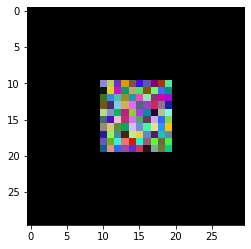

In [8]:
im1 = torch.rand(10,10,3).numpy()
im1 = np.pad(im1, ((im1.shape[0], im1.shape[0]), (im1.shape[1], im1.shape[1]), (0, 0)), 'constant')
plt.imshow(im1)

In [9]:

# im1 = timg[0].cpu()#torch.rand(3, 10,10)

# pad_image = T.Pad((im1.shape[1], im1.shape[2]), fill=0, padding_mode='constant')
# # pad_image = T.Pad((im1.shape[1], im1.shape[1], im1.shape[1], im1.shape[1]), fill=0, padding_mode='constant')

# im1 = pad_image(im1).permute(1, 2, 0).numpy()
# plt.imshow(im1)

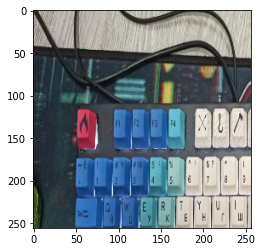

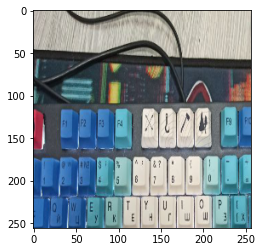

In [9]:
timg, timg_gray = load_dir(data_dir)
timg, timg_gray = torch_resize(timg, 1), torch_resize(timg_gray, 1)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

torch.Size([3, 256, 256])
torch.Size([3, 768, 768])


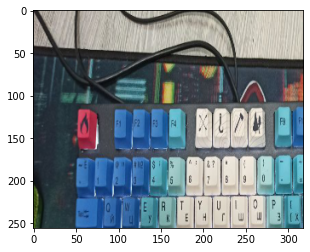

In [10]:
_idx = 0
stitch_res = stitch_images(timg_gray[1], timg_gray[_idx], timg[1], timg[_idx])
plt.imshow(stitch_res)

In [10]:
root_idx = find_root(timg_gray)

In [11]:
root_gray_img = timg_gray[root_idx]
gray_images_to_stitch = drop_by_idx(timg_gray, root_idx)

root_img = timg[root_idx]
images_to_stitch = drop_by_idx(timg, root_idx)

In [12]:
l = len(gray_images_to_stitch)
for i in range(l-1):
    maxLen = 0
    bestMatch = -1
    for j in range(1, len(gray_images_to_stitch)):
        kp1, kp2, goodMatches = get_keypoints(root_gray_img[None, ...], gray_images_to_stitch[j][None, ...])
        if len(goodMatches) > maxLen:
            maxLen = len(goodMatches)
            bestMatch = j
    
    stitch_res = stitch_images(root_gray_img, gray_images_to_stitch[bestMatch], root_img, images_to_stitch[bestMatch])
    root_img = torch.tensor(stitch_res).permute(2, 0, 1).to(device)
    gray_images_to_stitch = drop_by_idx(gray_images_to_stitch, bestMatch)
    images_to_stitch = drop_by_idx(images_to_stitch, bestMatch)

torch.Size([3, 256, 256])
torch.Size([3, 768, 768])
torch.Size([3, 257, 380])
torch.Size([3, 1017, 894])
torch.Size([3, 257, 442])
torch.Size([3, 1141, 956])
torch.Size([3, 392, 442])
torch.Size([3, 1276, 1226])
torch.Size([3, 391, 441])
torch.Size([3, 1273, 1223])
torch.Size([3, 391, 440])
torch.Size([3, 1271, 1222])
torch.Size([3, 528, 502])
torch.Size([3, 1532, 1558])
torch.Size([3, 664, 501])
torch.Size([3, 1666, 1829])


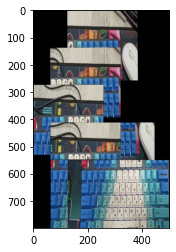

In [13]:
plt.imshow(root_img.permute(1, 2, 0).cpu().numpy())